**Томилов Матвей, 5130901/20103**

### *Упражнение 3.1.*

Сравним заданные оконные функции - стандартной hamming и bartlett, blackman, hanning.

Для начала создадим синусоидальный сигнал с частотой 440 так, чтобы он начинался с 0 и заканчивался в 1.


Код и полученная спектрограмма выглядят так:


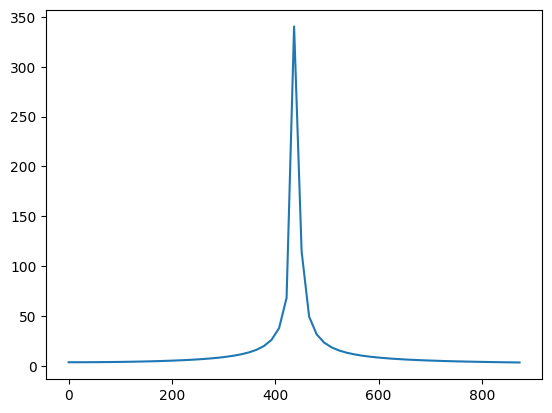

In [40]:
from source_files.thinkdsp import SinSignal
import matplotlib.pyplot as plt
import numpy as np

signal = SinSignal(freq=440)
duration = signal.period * 30.25
wave = signal.make_wave(duration)
spectrum = wave.make_spectrum()
spectrum.plot(high=880)

Теперь применим к полученной спектрограмме различные оконные функции:

Text(0.5, 0, 'Frequency (Hz)')

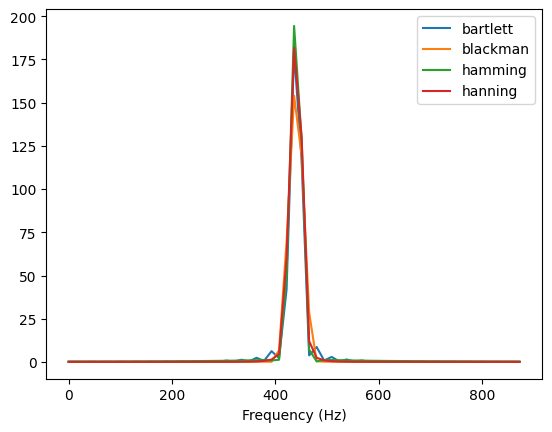

In [41]:
for window_func in [np.bartlett, np.blackman, np.hamming, np.hanning]:
    wave = signal.make_wave(duration)
    wave.ys *= window_func(len(wave.ys))

    spectrum = wave.make_spectrum()
    spectrum.plot(high=880, label=window_func.__name__)
plt.legend(loc='best')
plt.xlabel('Frequency (Hz)')

Полученный рисунок наглядно демонстрирует превосходство функции Хэмминга над остальными - поэтому она и является стандартным  вариантом.

### *Упражнение 3.2.*

Необходимо создать класс, расширяющий Chirp для создания линейно увеличивающегося пилообразного сигнала:

Получившаяся функция совмещает в себе функцию для создания Chirp и SawtoothSignal, написанную в пункт 2.1:


In [42]:
from source_files.thinkdsp import Chirp
from source_files.thinkdsp import normalize, unbias, PI2, decorate
import numpy as np

class SawtoothChirp(Chirp):

    def evaluate(self, ts):
        freqs = np.linspace(self.start, self.end, len(ts))
        dts = np.diff(ts, prepend=0)
        dphis = PI2 * freqs * dts
        phases = np.cumsum(dphis)
        cycles = phases / PI2
        frac, _ = np.modf(cycles)
        ys =  normalize(unbias(frac), self.amp)
        return ys

Создадим экземпляр описанного класса с начальной и конечной частотами - 220 и 880 соответственно.

Как итог, получаем пилообразный чирп, что можно услышать на аудиозаписи:

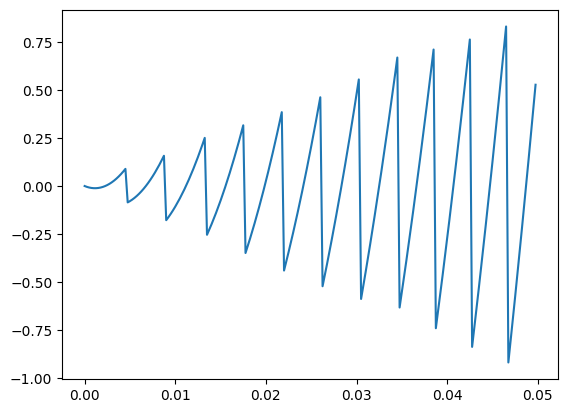

In [43]:
signal = SawtoothChirp(start=220, end=880)
wave = signal.make_wave(duration=1, framerate=4000)
wave.apodize()
wave.segment(duration=0.05).plot()
wave.make_audio()

Отметим, что небольшой фреймрейт сказался на получении достаточно шумного спектра из-за *биения*- этот эффект хорошо заметен, как «отражающиеся» от верхней границы рисунка темные линии.

Получившаяся спектрограмма выглядит следующим образом:

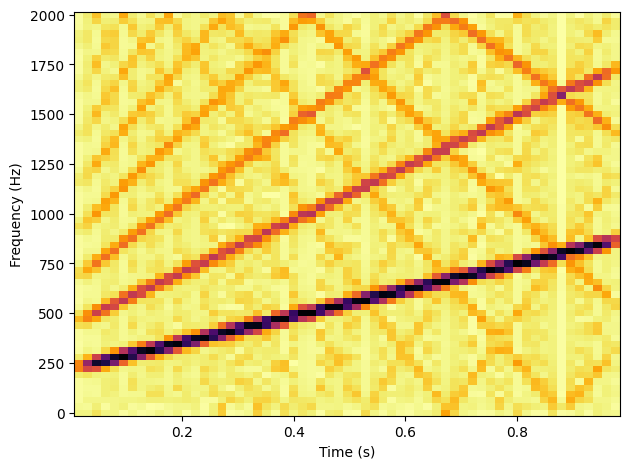

In [44]:
sp = wave.make_spectrogram(128)
sp.plot()
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

### *Упражнение 3.3.*

Создадим пилообразный чирп, меняющийся от 2500 до 3000 Гц. На его основе сгенерируем сигнал 1с и фреймрейтом 20000 Гц.

Пилообразный сигнал содержит и четные, и нечетные гармоники, уменьшающиеся пропорционально 1⁄f, поэтому можно предположить, что первый пик будет растянут между начальной и конечной частотой, второй будет в 2 раза меньше - на частотах 5000-6000, а третий будет на частотах 7500-9000 Гц и в 3 раза меньше первого пика.

Ожидаемо, спектрограмма соответстуем нашему предположению и выглядит следующим образом:


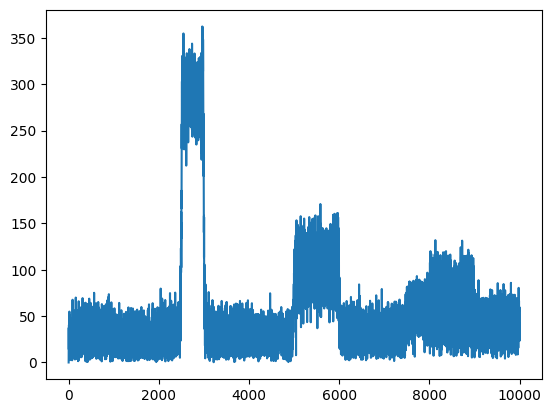

In [45]:
signal = SawtoothChirp(start=2500, end=3000)
wave = signal.make_wave(duration=1, framerate=20000)
wave.make_spectrum().plot(scalex=500)
wave.make_audio()

### *Упражнение 3.4.*
Скачаем пример глиссандо - нота, которая меняется от одной высоты к другой, и создадим его спектрограмму.

Заметим, что частота меняется вместе с изменением высоты ноты (в конце произведения нота практически не меняется).

Полученная спектрограмма выглядит следующим образом:

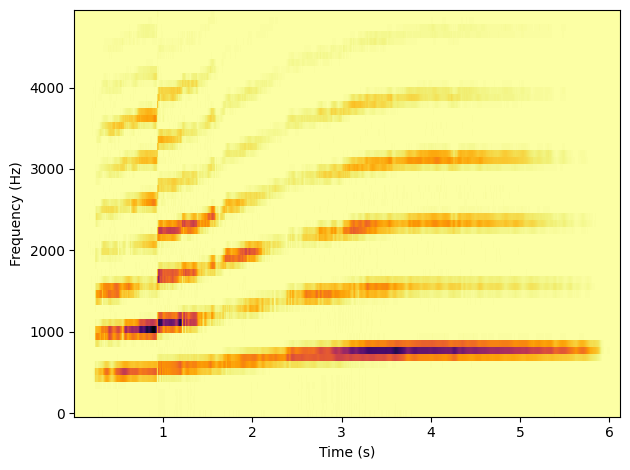

In [46]:
from source_files.thinkdsp import read_wave, decorate
wave = read_wave('72475__rockwehrmann__glissup02.wav')
wave.make_audio()
wave.make_spectrogram(512).plot(high=5000)
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

### *Упражнение 3.5.*
Необходимо создать класс, который будет имитировать глиссандо на тромбоне. Учитываем, что скорость изменения трубы постоянна, а частота звука обратно пропорциональна длине:



In [47]:
from source_files.thinkdsp import Chirp, decorate, PI2
import numpy as np

class TromboneGliss(Chirp):

    def evaluate(self, ts):
        l1, l2 = 1.0 / self.start, 1.0 / self.end
        lengths = np.linspace(l1, l2, len(ts))
        freqs = 1 / lengths

        dts = np.diff(ts, prepend=0)
        dphis = PI2 * freqs * dts
        phases = np.cumsum(dphis)
        ys = self.amp * np.cos(phases)
        return ys

Имитируем изменение длины кулисы тромбона и объявляем функцию evaluate.
Получившаяся спектрограмма выглядит следующим образом:

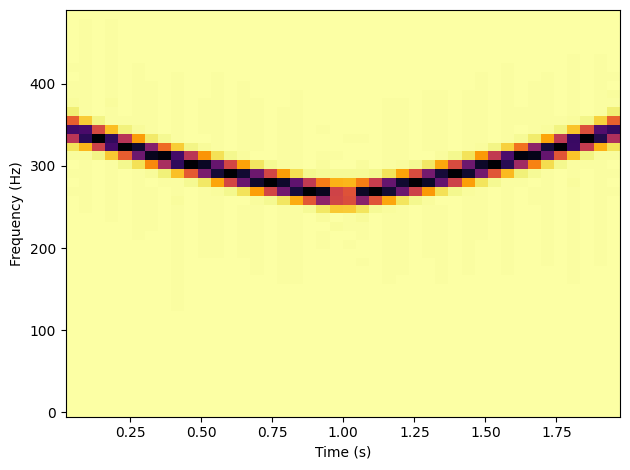

In [48]:
low = 262
high = 349
signal = TromboneGliss(high, low)
wave1 = signal.make_wave(duration=1)
wave1.apodize()
signal = TromboneGliss(low, high)
wave2 = signal.make_wave(duration=1)
wave2.apodize()
wave = wave1 | wave2
sp = wave.make_spectrogram(1024)
sp.plot(high=500)
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')
wave.make_audio()

Получившийся сигнал напоминает линейный - попробуем увеличить разброс до 800 Гц:

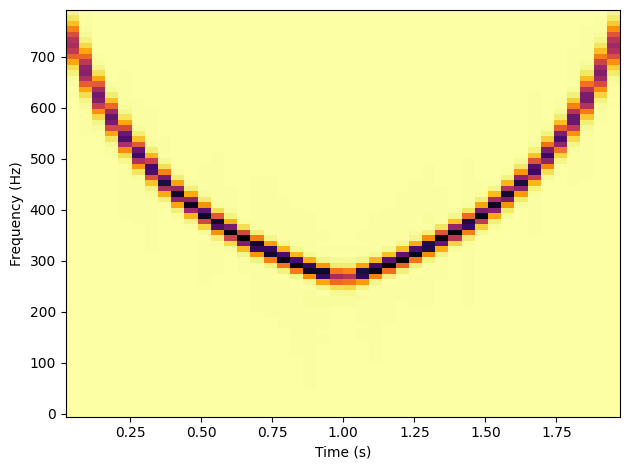

In [49]:
low = 262
high = 800
signal = TromboneGliss(high, low)
wave1 = signal.make_wave(duration=1)
wave1.apodize()
signal = TromboneGliss(low, high)
wave2 = signal.make_wave(duration=1)
wave2.apodize()
wave = wave1 | wave2
sp = wave.make_spectrogram(1024)
sp.plot(high=800)
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')
wave.make_audio()

Согласно полученному рисунку, теперь полученный сигнал больше похож на экспоненциальный, т. к. функция обратно пропорциональна длине, следовательно, функция степенная.

### *Упражнение 3.6.*
Теперь рассмотрим аудиофайл с гласными звуками и их спектрограммы. Необходимо понять, чем звуки отличаются друг от друга.

Загрузим аудио и посмотрим на спектрограмму:



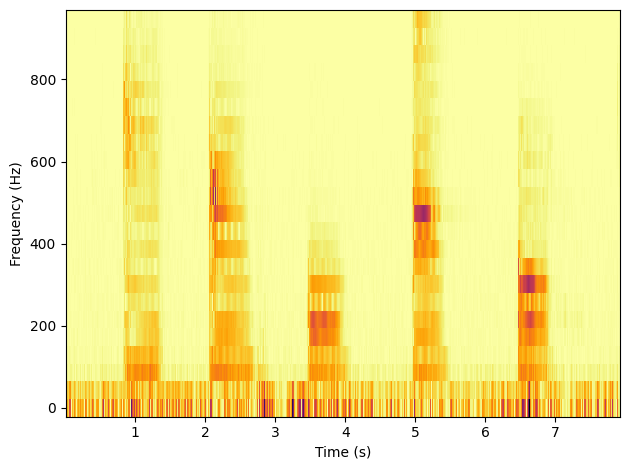

In [50]:
from source_files.thinkdsp import read_wave, decorate
wave = read_wave('87778__marcgascon7__vocals.wav')
wave.make_spectrogram(1024).plot(high=1000)
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')
wave.make_audio()

Попробуем взять первый звук ‘a’ и рассмотреть его спектрограмму:

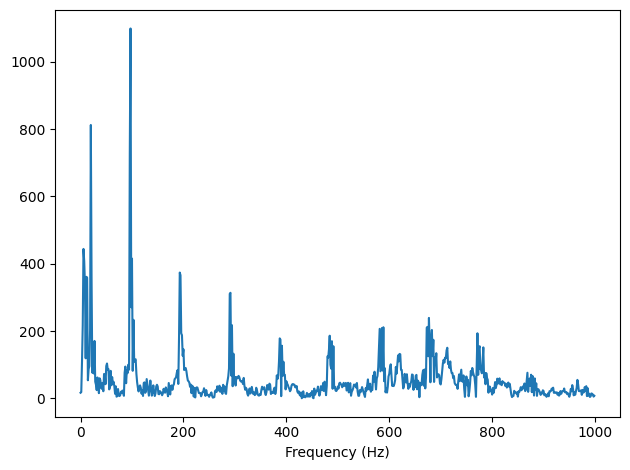

In [51]:
high = 1000

segment = wave.segment(start=0.8, duration=0.7)
segment.make_spectrum().plot(high=high)
decorate(xlabel='Frequency (Hz)')
segment.make_audio()

Теперь рассмотрим спектрограмму второго звука - "э":

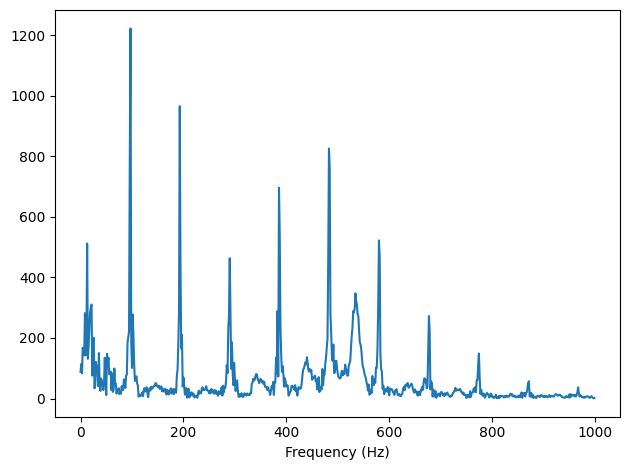

In [52]:
segment = wave.segment(start=2.1, duration=0.7)
segment.make_spectrum().plot(high=high)
decorate(xlabel='Frequency (Hz)')
segment.make_audio()

Теперь рассмотрим спектрограмму третьего звука - "и":

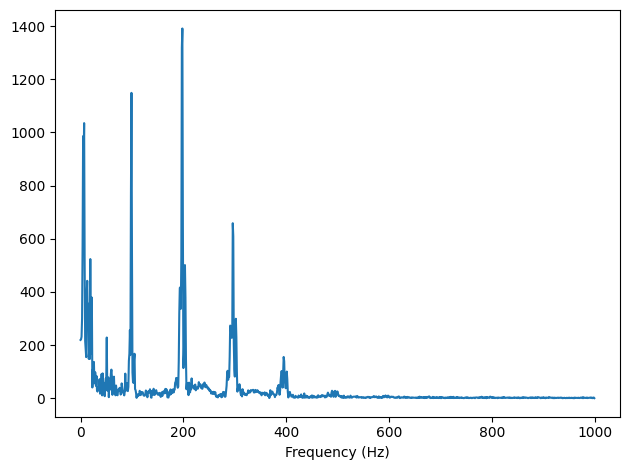

In [53]:
segment = wave.segment(start=3.2, duration=1)
segment.make_spectrum().plot(high=high)
decorate(xlabel='Frequency (Hz)')
segment.make_audio()

Теперь рассмотрим спектрограмму четвёртого звука - "о":

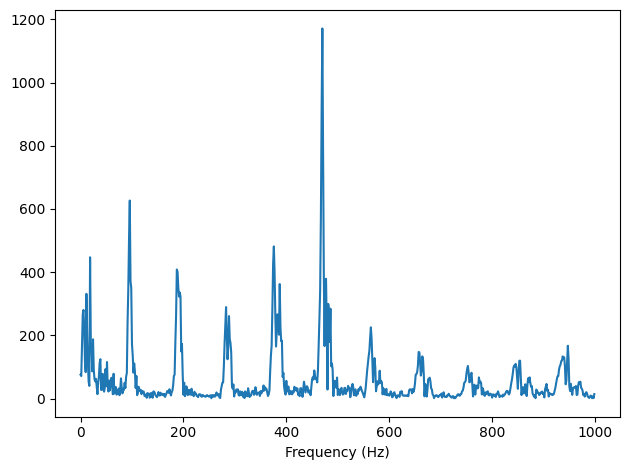

In [54]:
segment = wave.segment(start=5, duration=0.7)
segment.make_spectrum().plot(high=high)
decorate(xlabel='Frequency (Hz)')
segment.make_audio()

Теперь рассмотрим спектрограмму последнего звука - "у":

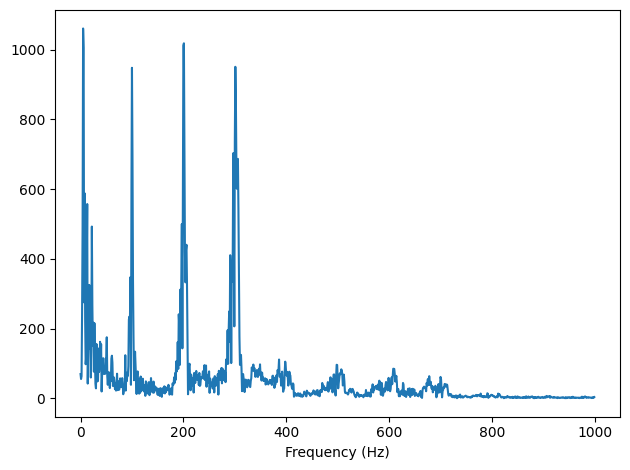

In [55]:
segment = wave.segment(start=6, duration=1)
segment.make_spectrum().plot(high=high)
decorate(xlabel='Frequency (Hz)')
segment.make_audio()

Полученные спектрограммы достаточно сильно отличаются друг от друга, хоть произносимые звуки и похожи между собой. Этот факт доказывает, что распознавание определённых звуков по их частоте - решаемая задача.